In [2]:
#import packages 
import numpy as np
import pandas as pd
import scipy.stats as sts
import os
import matplotlib.pyplot as plt
import scipy.optimize as opt
import warnings
warnings.filterwarnings('ignore')
from scipy import special
from scipy.integrate import quad
import requests

In [3]:
# Download and save the data file 
path = '/Users/shengshiyuan/Desktop/BootCamp2018/ProbSets/Econ/ProbSet5'
data = np.loadtxt(os.path.join(path, 'clms.txt'))
data

array([361.65, 123.04, 541.77, ...,  97.43, 186.88, 119.19])

1.0000000000000009


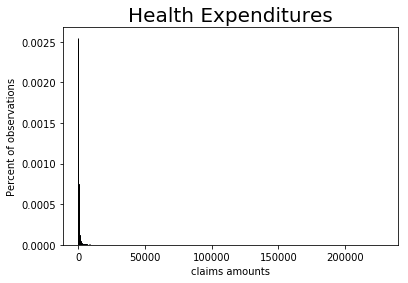

In [14]:
#create histogram 

count, bins, ignored = plt.hist(data, 1000, normed = True,
                                edgecolor='k')
plt.title('Health Expenditures', fontsize=20)
plt.xlabel('claims amounts')
plt.ylabel('Percent of observations')
print(sum(np.diff(bins)*count))

0.8489961389961361


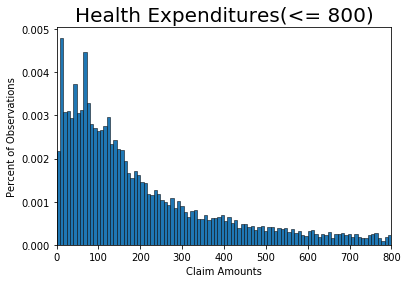

In [17]:
data_part = np.asarray([x for x in data if x <=800])
weights = (1 / data.shape[0]/8) * np.ones_like(data_part)
n, bins, ignored = plt.hist(data_part, 100, weights=weights, edgecolor='black',
                                linewidth=0.5)
plt.title('Health Expenditures(<= 800)', fontsize=20)
plt.xlabel('Claim Amounts')
plt.ylabel('Percent of Observations')
plt.xlim(0, 800)
print(sum(np.diff(bins)*n))

The second one is preferred because deleting outliers makes the graph more readable. 

# Gamma Dist

In [18]:
beta_guess = (data.var())/data.mean()
alpha_guess = data.mean()/beta_guess  
params_guess = (alpha_guess, beta_guess)

In [19]:
def GA_pdf(xvals, alpha, beta):

    pdf_vals = 1/((beta ** alpha) * special.gamma(alpha)) * (xvals ** (alpha - 1)) * np.exp(-xvals/beta)
    return pdf_vals

def log_lik_GA(xvals, alpha, beta):
  
    pdf_vals = GA_pdf(xvals, alpha, beta)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

In [20]:
def crit(params, args):
    
    alpha, beta = params
    xvals = args
    log_lik_val = log_lik_GA(xvals, alpha, beta)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [23]:
ga_args = data
bnds = ((1e-6, None), (1e-6, None))
results = opt.minimize(crit, params_guess, args=(ga_args), method ='L-BFGS-B', bounds=bnds)
alpha_ga, beta_ga = results.x
print(results)


      fun: 82076.45160566256
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.        , 0.09022187])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 33
      nit: 8
   status: 0
  success: True
        x: array([2.21755323e-01, 2.19110647e+04])


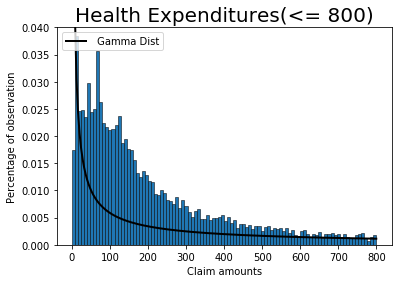

In [28]:
# Plot the histogram of the data
data_part = np.asarray([x for x in data if x <=800])

weights = (1 / data.shape[0]) * np.ones_like(data_part)
n, bins, ignored = plt.hist(data_part, 100, weights=weights, edgecolor='black',
                                linewidth=0.5)
plt.title('Health Expenditures(<= 800)', fontsize=20)
plt.xlabel('Claim amounts')
plt.ylabel('Percentage of observation')

x = np.linspace(1e-10, 800, 200)
y = 8*GA_pdf(x, alpha_ga, beta_ga)
plt.plot(x, y,'k-',
         linewidth=2, label=' Gamma Dist')
plt.legend(loc='upper left')
plt.ylim(0, 0.04)

plt.show()

# Generalized Gamma Dist

In [46]:
beta_guess = beta_ga
alpha_guess = alpha_ga
m_guess = 1
params_guess = (alpha_guess, beta_guess, m_guess) 

In [52]:
def GG_pdf(xvals, alpha, beta, m):

    pdf_vals = m/((beta**alpha)*special.gamma(alpha/m))*(xvals**(alpha - 1))*np.exp(-(xvals/beta)**m)
    return pdf_vals

def log_lik_GG(xvals, alpha, beta, m):
  
    pdf_vals = m/((beta**alpha)*special.gamma(alpha/m))*(xvals**(alpha - 1))*np.exp(-(xvals/beta)**m)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

def crit_GG(params, args):
    
    alpha, beta, m = params
    xvals = args
    log_lik_val = log_lik_GG(xvals, alpha, beta, m)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [48]:
gg_args = data
bnds = ((1e-6, None), (1e-6, None), (1e-6, None))
results = opt.minimize(crit_GG, params_guess, args=(gg_args), method ='L-BFGS-B', bounds=bnds)
alpha_gg, beta_gg, m_gg = results.x
print(results)

      fun: 82076.44679084865
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.65253072,  0.09167707, -1.04337232])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 24
      nit: 2
   status: 0
  success: True
        x: array([2.21737619e-01, 2.19110644e+04, 9.97091566e-01])


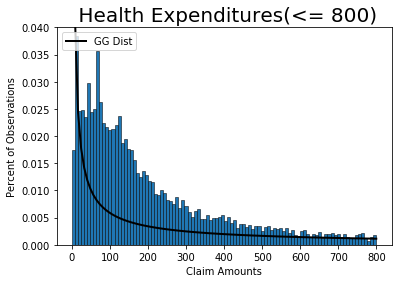

In [53]:

weights = (1 / data.shape[0]) * np.ones_like(data_part)
n, bins, ignored = plt.hist(data_part, 100, weights=weights, edgecolor='black',
                                linewidth=0.5)
plt.title(' Health Expenditures(<= 800)', fontsize=20)
plt.xlabel('Claim Amounts')
plt.ylabel('Percent of Observations')

x = np.linspace(1e-10, 800, 100)
y = 8 * GG_pdf(x, alpha_gg, beta_gg, m_gg)
plt.plot(x, y,'k-',
         linewidth=2, label='GG Dist')
plt.legend(loc='upper left')
plt.ylim(0, 0.04)

plt.show()

# Generalized Beta 2 Dist

In [57]:
q_guess = 6200
a_guess = m_gg
b_guess = q_guess**(1/a_guess)*beta_gg
p_guess = alpha_gg/m_gg

In [54]:
def GB2_pdf(xvals, a, b ,p, q):
    x = a*xvals**(a*p-1)
    y = (b**(a*p))*special.beta(p,q)*((1+(xvals/b)**a)**(p+q))
    pdf_vals = x/y
    return pdf_vals

def log_lik_GB2(xvals, a, b, p, q):
  
    pdf_vals = GB2_pdf(xvals, a, b, p, q)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

def crit_GB2(params, args):
    
    a, b, p, q = params
    xvals = args
    log_lik_val = log_lik_GB2(xvals, a, b, p, q)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [58]:
params_guess = (a_guess, b_guess, p_guess, q_guess) 

gb2_args = data
bnds = ((1e-6, None), (1e-6, None), (1e-6, None), (1e-6, None))
results = opt.minimize(crit_GB2, params_guess, args=(gb2_args), method ='L-BFGS-B', bounds=bnds)
a_gb2, b_gb2, p_gb2, q_gb2 = results.x
print(results)

      fun: 76397.04283027737
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.7459464 ,  0.        ,  2.61788955,  1.86118996])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 120
      nit: 13
   status: 0
  success: True
        x: array([6.82691194e-01, 1.39353300e+08, 1.04593255e+00, 6.19917275e+03])


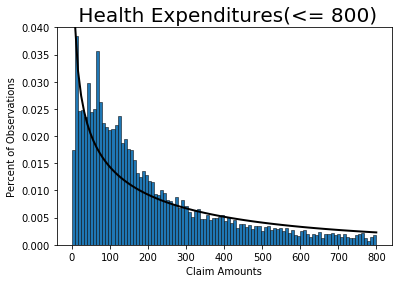

In [61]:
data_part = np.asarray([x for x in data if x <=800])
weights = (1 / data.shape[0]) * np.ones_like(data_part)
n, bins, ignored = plt.hist(data_part, 100, weights=weights, edgecolor='black',
                                linewidth=0.5)
plt.title(' Health Expenditures(<= 800)', fontsize=20)
plt.xlabel('Claim Amounts')
plt.ylabel('Percent of Observations')

x = np.linspace(1e-10, 800, 100)
y = 8 * GB2_pdf(x, a_gb2, b_gb2, p_gb2, q_gb2)
plt.plot(x, y,'k-',
         linewidth=2)

plt.ylim(0, 0.04)

plt.show()

#  Likelihood ratio test


In [63]:
GB2 = log_lik_GB2(data, a_gb2, b_gb2, p_gb2, q_gb2)
GG = log_lik_GG(data, alpha_gg, beta_gg, m_gg)
GA = log_lik_GA(data, alpha_ga, beta_ga)
GG_val = abs(2 * (GG - GB2))
GA_val = abs(2 * (GA - GB2))
pval_GG = 1.0 - sts.chi2.cdf(GA_val, 4)
pval_GA = 1.0 - sts.chi2.cdf(GA_val, 4)
print('chi squared of H0 with 4 degrees of freedom p-value (Generalized Gamma Distribution) = ', pval_GG)
print('chi squared of H0 with 4 degrees of freedom p-value (Gamma Distribution) = ', pval_GA)

chi squared of H0 with 4 degrees of freedom p-value (Generalized Gamma Distribution) =  0.0
chi squared of H0 with 4 degrees of freedom p-value (Gamma Distribution) =  0.0


In [64]:
g1 = lambda x: GB2_pdf(x, a_gb2, b_gb2, p_gb2, q_gb2)
g2 = lambda x: GA_pdf(x, alpha_ga, beta_ga)
print("Prediction using GB2: "+ str(quad(g1, 1000, np.inf)[0]))
print("Prediction using GA: "+ str(quad(g2, 1000, np.inf)[0]))

Prediction using GB2: 0.15952542171837628
Prediction using GA: 0.45195974447843174
